# This notebook will have the final chosen model with all of its functions

## Functions and data

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split 

In [2]:
# Define compute device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# set seed for reproducibility
torch.manual_seed(42)

Using cuda device


### Dataset

In [3]:
# download cifar10 dataset
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Create a validation dataset using stratified split on the training dataset
# The set would be used for bias and variance calculations and early stopping
labels = [label for (_, label) in train_data]
train_indices, val_indices = train_test_split(
    range(len(train_data)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = torch.utils.data.Subset(train_data, train_indices)
val_subset = torch.utils.data.Subset(train_data, val_indices)
# Create data loaders as baseline for the models - might be changed for later models
batch_size = 128
train_dataloader = DataLoader(train_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_subset, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## General functions

In [4]:
# Train with early stopping
# Training loop
def early_stopping_train(train_loader, val_loader, model, loss_function, optimizer, epochs, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    # Early stopping
    best_val_loss = np.inf
    best_model = None
    patience = patience
    
    for epoch in range(epochs):
        print(f"-------------------------------\nEpoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        total_train_loss = 0
        train_correct = 0
        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)
            
            # Forward + Backpropagation
            pred = model(X)
            loss = loss_function(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track loss/accuracy
            total_train_loss += loss.item() * X.size(0)  # Scale by batch size
            train_correct += (pred.argmax(1) == y).sum().item()
            
            
        # Training metrics
        avg_train_loss = total_train_loss / len(train_dataloader.dataset)
        train_accuracy = train_correct / len(train_dataloader.dataset)
        train_loss.append(avg_train_loss)
        train_acc.append(train_accuracy)
        
        # Validation
        model.eval()
        total_val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                pred_val = model(X_val)
                loss_val = loss_function(pred_val, y_val)
                
                total_val_loss += loss_val.item() * X_val.size(0)
                val_correct += (pred_val.argmax(1) == y_val).sum().item()

        # Validation metrics
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        val_loss.append(avg_val_loss)
        val_acc.append(val_accuracy)
        
        # Early stopping
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            torch.save(model.state_dict(), f'{model}--best_model.pth')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_accuracy:.1f}%")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {100*val_accuracy:.1f}%")

    return train_loss, val_loss, train_acc, val_acc

In [5]:
# Training loop
def train(train_loader, val_loader, model, loss_function, optimizer, epochs):
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []
    
    for epoch in range(epochs):
        print(f"-------------------------------\nEpoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        total_train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            # Forward + Backpropagation
            pred = model(X)
            loss = loss_function(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track loss/accuracy
            total_train_loss += loss.item() * X.size(0)  # Scale by batch size
            train_correct += (pred.argmax(1) == y).sum().item()
            
            
        # Training metrics
        avg_train_loss = total_train_loss / len(train_dataloader.dataset)
        train_accuracy = train_correct / len(train_dataloader.dataset)
        train_loss_values.append(avg_train_loss)
        train_acc_values.append(train_accuracy)
        
        # Validation
        model.eval()
        total_val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                pred_val = model(X_val)
                loss_val = loss_function(pred_val, y_val)
                
                total_val_loss += loss_val.item() * X_val.size(0)
                val_correct += (pred_val.argmax(1) == y_val).sum().item()

        # Validation metrics
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        val_loss_values.append(avg_val_loss)
        val_acc_values.append(val_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_accuracy:.1f}%")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {100*val_accuracy:.1f}%")

    return train_loss_values, val_loss_values, train_acc_values, val_acc_values

In [7]:
def evaluate(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    
    accuracy = 100 * correct
    test_loss
    
    return accuracy, test_loss

In [8]:
# Calculate the bias and variance of the model
def bias_variance(train_loss, val_loss):
    bias = np.mean(train_loss)
    variance = np.mean(val_loss) - bias
    return bias, variance

In [9]:
def print_time_taken(start_time, current_time):
    elapsed_time = current_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Time taken: {minutes} minutes and {seconds} seconds")

In [10]:
def plot_loss(train_loss, val_loss=None):
    plt.plot(train_loss, label="Train Loss")
    if val_loss:
        plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [11]:
# A general "run experiment" function to handle most of the things I tried
def run_experiment(model, learning_rate=1e-3, epochs=100, optimizer_name='adam',weight_decay=None, momentum=None, save_path=None, early_stopping=False, patience=5):
    start_time = time.time()
    model = model.to(device)
    
    # Set the optimizer parameters if specified in the function call
    optimizer_params = {'lr': learning_rate}
    if weight_decay:
        optimizer_params['weight_decay'] = weight_decay
    
    # Initialize the optimizer based on the optimizer name
    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
        
    elif optimizer_name.lower() == 'sgd':
        if momentum: # Check if momentum is specified only for SGD
            optimizer_params['momentum'] = momentum
        optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
    else:
        raise ValueError("Invalid optimizer name")
    
    # Initialize the loss function
    loss_function = nn.CrossEntropyLoss()
    
    
    # Train the model
    if early_stopping:
        train_loss, val_loss, train_acc, val_acc = early_stopping_train(train_dataloader, val_loader, model, loss_function, optimizer, epochs, patience=p)
        # Load the best model state
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
    else:
        train_loss, val_loss, train_acc, val_acc = train(train_dataloader, val_loader, model, loss_function, optimizer, epochs)
        
    # calculate the bias and variance of the model
    bias, variance = bias_variance(train_loss, val_loss)
    
    # Calculate the model accuracy on the test set
    test_accuracy, test_loss = evaluate(test_dataloader, model, loss_function)
    
    #print(f"Time taken: {seconds_to_minutes(time - start_time())}")
    print_time_taken(start_time, time.time())
    
    print("Test results:")
    
    print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")
    
    print(f"Bias: {bias}, Variance: {variance}")
    
    plot_loss(train_loss, val_loss)
    
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved PyTorch Model State to {save_path}")
    

# The final model

In [12]:
class CIFAR10CNNew(nn.Module):
    def __init__(self):
        super(CIFAR10CNNew, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = self.classifier(x)
        return x

-------------------------------
Epoch 1/200
Train Loss: 1.7731 | Train Acc: 36.1%
Val Loss: 1.6084 | Val Acc: 45.5%
-------------------------------
Epoch 2/200
Train Loss: 1.2259 | Train Acc: 55.8%
Val Loss: 1.3126 | Val Acc: 55.8%
-------------------------------
Epoch 3/200
Train Loss: 1.0138 | Train Acc: 64.3%
Val Loss: 1.2358 | Val Acc: 57.4%
-------------------------------
Epoch 4/200
Train Loss: 0.8669 | Train Acc: 69.6%
Val Loss: 1.1198 | Val Acc: 62.2%
-------------------------------
Epoch 5/200
Train Loss: 0.7803 | Train Acc: 73.0%
Val Loss: 0.8809 | Val Acc: 71.1%
-------------------------------
Epoch 6/200
Train Loss: 0.7055 | Train Acc: 75.5%
Val Loss: 0.9210 | Val Acc: 69.2%
-------------------------------
Epoch 7/200
Train Loss: 0.6478 | Train Acc: 77.7%
Val Loss: 0.8345 | Val Acc: 72.4%
-------------------------------
Epoch 8/200
Train Loss: 0.5977 | Train Acc: 79.6%
Val Loss: 0.8377 | Val Acc: 71.7%
-------------------------------
Epoch 9/200
Train Loss: 0.5422 | Train A

C:\Users\almog\AppData\Local\Temp\ipykernel_28832\3307783047.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('--best_model.pth'))


Time taken: 13.0 minutes and 2.3278682231903076 seconds
Test results:
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.003707
Bias: 0.2279915613854694, Variance: 0.369168381185483


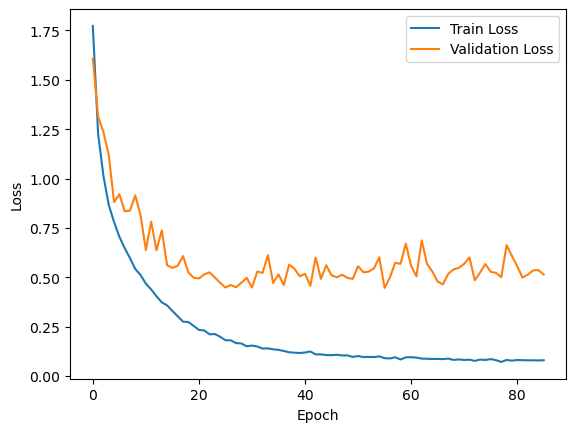

Saved PyTorch Model State to CIFAR10CNNew.pth


In [39]:
run_experiment(CIFAR10CNNew(), learning_rate=0.001, epochs=200, optimizer_name='adam', weight_decay=1e-4, save_path="CIFAR10CNNew.pth", early_stopping=True, patience=20)